### <span style="color:rgb(139,69,19)">CIMPA School Research School "Control, Optimization, and Model Reduction in Machine Learning"</span>

### <span style="color:rgb(139,69,19)">Optimization for Machine Learning - C. W. Royer</span>


# <span style="color:rgb(139,69,19)">Lab 03 - Differentiation and Optimization in machine learning</span>

For better performance of execution, Parts 2 and 3 of this notebook can be run through [Google Colabs](https://colab.research.google.com/notebooks/welcome.ipynb) (requires a Google account).

#### <span style="color:rgb(139,69,19)">Preliminary remarks</span>

The goal of this lab session is to illustrate the use of subgradients in optimization, as well as the calculation of (sub)gradients through automatic differentiation.

In [ ]:
# Pytorch - Neural network training
import torch # Main library
import torch.nn as nn # Neural network packages
import torch.autograd as autograd # Automatic differentiation
import torch.optim as optim # Built-in optimization algorithms
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.backends import cudnn # CUDA neural networks
cudnn.benchmarks = True
import time

# Other imports
# Display
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Square root
from math import ceil # Ceil integer operator
from math import log # Logarithm function
# NumPy - Matrix and vector structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn, uniform, choice # Probability distributions

# SciPy - Efficient mathematical calculation
from scipy.linalg import norm # Euclidean norm
from scipy.linalg import toeplitz # Toeplitz matrices
from scipy.linalg import svdvals # Singular value decomposition
from scipy.linalg import qr # QR decomposition from linear algebra
from scipy.optimize import check_grad # Check derivatives
from scipy.optimize import fmin_l_bfgs_b # Efficient method for minimization

# <span style="color:rgb(139,69,19)">1 - Robust linear regression and subgradient method</span>

In this first section, we consider a variant on linear regression. Given a dataset $(\mathbf{X},\mathbf{y})$ for regression, we again aim at computing a linear model parameterized by a vector $\mathbf{w} \in \mathbb{R}^d$. In the previous sections, we considered the least-squares loss
$$
    \mathrm{minimize}_{\mathbf{w} \in \mathbb{R}^d} 
    \frac{1}{2n}\left\| \mathbf{X}\mathbf{w}-\mathbf{y} \right\|_2^2 
    =\frac{1}{2n}\sum_{i=1}^n (\mathbf{x}_i^T \mathbf{w}-y_i)^2.
$$

When the dataset contains outliers, linear regression can produce poor results. An alternate optimization formulation, less sensitive to outliers, consists in replacing the $\ell_2$ norm by the $\ell_1$ norm in the objective, yielding
$$
    \mathrm{minimize}_{\mathbf{w} \in \mathbb{R}^d} 
    \frac{1}{n}\left\| \mathbf{X}\mathbf{w}-\mathbf{y} \right\|_1 
    = \frac{1}{n}\sum_{i=1}^n |\mathbf{x}_i^T \mathbf{w}-y_i|.
$$

## <span style="color:rgb(139,69,19)">1.1 Dataset</span>

The code below implements a dataset with outliers, which can be observed directly in dimension $1$.

In [ ]:
# Data generation
# This generating technique is adapted from J. Duchi (Stanford)
def data_outliers(d, n, rng):
    
    """
    Linear model with a proportion of outliers
    
    Inputs
    ----------
        d : Parameters
    
        n : Samples
        
        rng : Random number generator
        
    Outputs
    ----------
    
        X,y: Feature matrix and label vector
    """    
    
    X = rng.multivariate_normal(np.zeros(d), np.eye(d), size=n)
    u = rng.multivariate_normal(np.zeros(d), np.eye(d))
    noise = rng.normal(0.0,1.0,size=n)
    y = X.dot(u) + noise*np.power(np.abs(noise),3)
    return X, y

In [ ]:
# Visualization of 1D data
rng= np.random.default_rng(4)

x0,y0=data_outliers(1,200,rng)
plt.figure(figsize=(7, 5))
plt.scatter(x0,y0, label="Samples", lw=2)
plt.title("Dataset with outliers", fontsize=16)
plt.legend()

In the next section, we will use a higher-dimensional (yet still small-dimensional) dataset.

In [ ]:
# Dataset to be used in the next section

d=50
n=100

rng= np.random.default_rng(4)

X,y=data_outliers(d,n,rng)

For any $\mathbf{w} \in \mathbb{R}^d$, a subgradient of $f$ is given by
$$
    g(\mathbf{w}) = \frac{1}{n}\mathbf{X}^T \mbox{sign}(\mathbf{X}\mathbf{w}-\mathbf{y}), 
    \qquad 
    \mbox{sign}(\mathbf{X}\mathbf{w}-\mathbf{y})
    =
    \begin{bmatrix} 
    \mbox{sign}(\mathbf{x}_1^T \mathbf{w}-y_1) \\ 
    \vdots \\
    \mbox{sign}(\mathbf{x}_n^T \mathbf{w}-y_n)
    \end{bmatrix},
    \qquad
    \mbox{sign}(t) = 
        \left\{
        \begin{array}{ll}
            1 &\mbox{if } t>0 \\
            -1 &\mbox{if } t<0 \\
            0 &\mbox{if } t=0.
        \end{array}
        \right.
$$

In [ ]:
# Tailored subgradient algorithm for robust linear regression
def sub_grad(X,y,w0,stepchoice=0,step0=1, n_iter=4000,verbose=False): 
    """
        Subgradient algorithm for robust linear regression with l1 loss.
        
        Inputs:
            X: Data matrix (features)
            y: Data vector (labels)
            w0: Initial point
            stepchoice: Stepsize choice
                0: Constant proportional to 1/L (L Lipschitz constant for the gradient)
                a>0: Decreasing, set to 1/((k+1)**a)
            step0: Initial stepsize
            n_iter: Maximum number of iterations
            verbose: Plot information at the iteration level?
            
        Outputs:
            w_output: Last iterate
            objvals: History of function values at the iterates
            objavg: History of function values at the averatges
    """
    
    ############
    # Initialization
    objvals = []
    objavg = []
    
    
    # Dimensions
    (n,d) = X.shape
    
    # Initial point
    w = w0.copy()
    
    # Average of iterates
    wavg=w0.copy()

    k=0
    
    obj = norm(X.dot(w)-y,1) 
    objvals.append(obj)
    objavg.append(obj)
    
    if verbose:
        # Optional display
        print("Subgradient, robust regression",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "favg"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % obj).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter):
        
        
        # Compute subgradient
        sg = (1/n)*X.T@np.sign(X.dot(w)-y)
            
        if stepchoice==0:
            w[:] = w - step0 * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            w[:] = w - sk * sg
            
        obj = norm(X.dot(w)-y,1)
        
        # Maintain a running average of the iterates
        wavg = k/(k+1) *wavg + w/(k+1) 
        obj_wavg = norm(X.dot(wavg)-y,1)
        

        k += 1
        
        # Record objective values for both the iterate sequence and the average sequence
        objvals.append(obj)
        objavg.append(obj_wavg)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % obj_wavg).rjust(8)]))       
    
    # End main loop
    #################
    
    # Solution
    w_output = w.copy()
    
    return w_output, np.array(objvals), np.array(objavg)

### <span style="color:rgb(139,69,19)">Hands on! Subgradient</span>

**Run the subgradient method below with different constant stepsize choices. Use at least one value <1 and one value $\ge$ 1.**

In [ ]:
# Experiments on subgradient methods

w0 = np.zeros(d)

###############################################
# TO BE COMPLETED
# Choose stepsizes greater and smaller than 1
cst_step = []
###############################################


nvals = len(cst_step)
nits = 4000

objs = np.zeros((nits+1,nvals))
avgs = np.zeros((nits+1,nvals))

for val in range(nvals):
    _, objs[:,val], avgs[:,val] = sub_grad(X,y,w0,stepchoice=0,step0=cst_step[val],n_iter=nits)

In [ ]:
# Plotting objective values (iterates+average)
plt.figure(figsize=(7, 5))
plt.set_cmap("RdPu")
for val in range(nvals):
    plt.semilogy(objs[:,val], label="alpha="+str(cst_step[val]), lw=2)
plt.title("Objective values (iterates)", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective (log)", fontsize=14)
plt.legend(loc=1)

plt.figure(figsize=(7, 5))
plt.set_cmap("RdPu")
for val in range(nvals):
    plt.semilogy(avgs[:,val], label="alpha="+str(cst_step[val]), lw=2)
plt.title("Objective values (average)", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective (log)", fontsize=14)
plt.legend(loc=1)

# <span style="color:rgb(139,69,19)">2 - Automatic differentiation</span>

Dans cette deuxième partie, on s'intéresse à la bibliothèque ``PyTorch``, l'une des plus populaires pour implémenter des réseaux de neurones. L'un des concepts cruciaux de cette bibliothèque est l'utilisation de différentiation automatique. On fournit ci-dessous une introduction élémentaire aux tenseurs PyTorch et de montrer leur utilisation dans le contexte de la différentiation automatique.

## <span style="color:rgb(139,69,19)">2.1. PyTorch tensors</span>

Tensors are multidimensional arrays, that generalize the concepts of scalars (0 dimension), vectors (1 dimension) and matrices (2 dimensions). PyTorch tensors are similar to NumPy arrays, and are at the heart of automatic differentiation in PyTorch. 

In [ ]:
# Several examples of PyTorch tensors

#  A vector of size 2
x1 = torch.tensor([10.0,20.0])
print(x1) # Tensor objects can be printed (yet difficult to visualize in many dimensions!)

#  A matrix of size 2x1
x2 = torch.tensor([[10],[20]])
print(x2)

#  A matrix of dimensions 1x2,
x3 = torch.tensor([[10,20]])
print(x3)

# A "0 dimension" tensor, i.e. a scalar
x4 = torch.tensor(3.0)
print(x4)

# A zero-filled matrix of size 3x4
x5 = torch.zeros(3,4)
print(x5)

# A 2x2 matrix with normal random coefficients
x6 = torch.randn(2,2)
print(x6)

Operations on PyTorch tensors work the same way as for NumPy arrays.

In [ ]:
# Add 3 to all elements
x5 = x1 + 3
print(x5)
# Square every elements in x5
x6 = x5 ** 2
print(x6)
# Fill a vector with zeros
x6.zero_()
print(x6)

In [ ]:
# Transpose a matrix
x7 = x2.t()
print(x7)

# Reshaping a vector
x8 = x7.view(2,1)
print(x8)

# Matrix multiplication (2 equivalent formulations)
x9 = torch.mm(x8,x7)
x10 = x8 @ x7
print(x9)
print(x10)

# Component-wise product
x11 = x7*x7
print(x11)

Importantly, it is possible to convert NumPy arrays to PyTorch tensors and vice-versa.

In [ ]:
# Convert a Pytorch to a NumPy array
x7_numpy = x7.numpy()

# Convert a NumPy array to a PyRorch array
a=np.arange(10) # Generates a NumPy array with a range of 10 values (by default, starts at 0 and values are spaced by 1)
print(a)
a_torch = torch.tensor(a,dtype=torch.float)
print(a_torch)

## <span style="color:rgb(139,69,19)">2.2 Autograd</span>

When creating a PyTorch tensor ``x``, one can ''track'' the gradient with respect to ``x`` of any subsequent function of ``x`` by specifying ``requires_grad=True`` in its definition.

In [ ]:
x=torch.ones(10,10,requires_grad=True)
y=3*x
print(y.grad_fn)

In the above example, the gradient with respect to x is tracked within the graph of dependencies of y with respect to x. The operations are recorded in the structure ``y.grad_fn``, and will be used to compute the gradient of ``y`` with respect to ``x``.

By default, ``requires_grad`` is set to ``True``. If *requires_grad*=*False*, no dependency will be tracked, as shown by the example below.

In [ ]:
# PyTorch tensors without tracking dependencies
x=torch.ones(10,10,requires_grad = False)
y=3*x
y =y.sum()


print(y.grad_fn)

Note that it is not possible to start tracking gradients once operations have been made on the graph.

In [ ]:
x=torch.ones(10,10,requires_grad = False)
y=3*x
y =y.sum()
print(y.grad_fn)
x.requires_grad_(True)
print(y.grad_fn)

We know turn to the actual gradient calculation process, which corresponds to a **backward pass** in the computational graph.

In [17]:
x=torch.ones(10,10,requires_grad = True)
y=3*x
y = y.sum()
y.backward()

Once this backward pass has been performed, the derivative of ``y`` with respect to ``x`` is available directly from ``x`` through the operation ``x.grad``.

In [ ]:
# x.grad plots the tensor of derivatives of y with respect to every component of x.
x.grad

In the previous example, y is a scalar (equal to 3 times the sum of elements of x). When y is a tensor, one then needs to specify a tensor w.r.t. which the derivation will be performed.

In [19]:
## INCORRECT WAY TO COMPUTE THE GRADIENT FOR A TENSOR-VALUED FUNCTION
## Uncommenting and executing the 3 lines below returns an error as y is not a scalar

#x=torch.ones(10,10,requires_grad = True)
#y=3*x
#y.backward()

In [ ]:
# Correct way to obtain gradients for a tensor-valued function 
# (Note: In this case, the gradient is sometimes called the Jacobian or the tensor derivative)
x=torch.ones(10,10,requires_grad = True)
y=3*x

y.backward(torch.ones(x.shape)) # Putting values other than ones here would scale the gradient
print(x.grad)

To obtain two or more gradients, we use the same process.

In [ ]:
# An example with a function of two (scalar) tensors.
# The call to backward() will compute the gradient w.r.t. both a and b
a = torch.ones(1, requires_grad = True)
b = torch.ones(1, requires_grad = True)
y=(a+4*b)**2
y.backward()
print(a.grad)
print(b.grad)

Remark: A *tracked tensor*, i.e. a tensor for which *requires_grad*=*True*, cannot be directly converted to a NumPy array. One first needs to detach the tracking of the variable.

In [ ]:
## The line below (commented out) generates an error
#a.numpy()

# This code is valid
x= a.detach()
print(x)
x_numpy = x.numpy()
print(x_numpy)

### <span style="color:rgb(139,69,19)">Hands on! Automatic differentiation in one dimension</span>

**Using PyTorch tensors and Autograd, compute the derivative of $f(x)=(1+x^2e^{-x})^{1/3}$. Run the block afterwards to compare your output with the actual derivative on [-1,1].**

*NB (solution version): The derivative is $f'(x) = - \frac{e^{-x}(x-2)x}{3(e^{-x}x^2+1)^{2/3}}$.*

In [ ]:
####################################
# Applying AD for a 1-dimensional function
####################################

# Creating a NumPy array with values in [-1,1]
v=np.arange(-1,1,0.02) # Other possibility: use np.linspace(-1,1,100)

###########################################
# FILL OUT THE CODE BELOW
# Create the PyTorch tensor containing the entries of v
x=
# Form the tensor containing the values f(x_i) for every coefficient x_i of x 
f=
# END PORTION TO BE FILLED OUT
############################################

# Calling backward on f (Important: f is a tensor, not a scalar)
f.backward(torch.ones(x.shape))
print(x.grad)

In [ ]:
# Plotting the values in f and x.grad

# Exact derivative calculation in NumPy (note how tedious it is!)
expv = np.exp(-v)
expsqv = np.multiply(expv,np.power(v,2))
derv = (-1/3)*np.divide(expsqv-2*np.multiply(np.exp(-v),v),np.power(expsqv+1,2/3))

# In order to plot them like NumPy arrays, we need to use the detach() function (see Section 1.1).
plt.figure(figsize=(7, 5))
plt.plot(v,f.detach().numpy(),'g',label='f(x)')
plt.plot(v,x.grad.detach().numpy(),'b',label="f'(x) - Diff auto")
plt.plot(v,derv,'orange',label="f'(x) - Exact",linestyle='--')
plt.legend()
plt.show()

### <span style="color:rgb(139,69,19)">Hands on! Automatic differentiation (``one layer'' NN)</span>

**Using PyTorch tensors and Autograd, compute the derivative of $f(x,A,b)=\frac{1}{2}\|Ax-b\|^2$ with respect to $x$ and $A$ evaluated at**

$$
    x_0 = \begin{bmatrix} 1 \\ \vdots \\ 1 \end{bmatrix} \in \mathbb{R}^d,
    \quad
    A_0 = \begin{bmatrix} 1 &\cdots &1 \\ 1 &\ddots &1 \\ 1 &\cdots &1 \end{bmatrix} \in \mathbb{R}^{n \times d},
    \quad 
    b_0 = \begin{bmatrix} 0 \\ \vdots \\ 0 \end{bmatrix} \in \mathbb{R}^n.
$$

**Knowing that Autograd actually returns the transpose of the Jacobian of $f$ with respect to $A$, find the right formula for $\mathrm{D}_A f(x,A,b)$ among those below:**

1) $Ax-b$
2) $A^T (Ax-b)$
3) $(Ax-b)x^T$

In [ ]:
# Hands-on: one layer NN

d=10
n=5
###########
# Fill out the code below

# Implement x0, A0, b0 and their Pytorch tensors counterparts
x_0 = 
x_lsq=
A_0 = 
A_lsq=
b_0 = 
b_lsq=

# Implement the objective function f_lsq as a tensor
f_lsq=

# Apply automatic differentiation and compute derivatives
f_lsq.backward()
print('Derivative w.r.t. x:\n',x_lsq.grad,'\n')
print('Derivative w.r.t. A:\n',A_lsq.grad,'\n')

# End part to be filled out
################################################

# Comparison with exact derivatives
print('Ax-b:\n',A_0@x_0-b_0,'\n')
print('A^T (Ax-b):\n',A_0.T@(A_0@x_0-b_0),'\n')
print('(Ax-b)x^T:\n',np.outer(A_0@x_0-b_0,x_0),'\n')

# <span style="color:rgb(139,69,19)"> 3 - Neural network training using PyTorch (bonus)</span>

In this part, we investigate implementations of stochastic gradient techniques that exploit momentum. To this end, we consider a standard classification task for the MNIST dataset, and the implementations of stochastic gradient available in PyTorch.

In [11]:
# We use data from MNIST, a dataset of handwritten digits
bs = 64

# Load MNIST data
train_data = torchvision.datasets.MNIST("datasets/", 
                                       train=True,
                                        transform=torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize(
                                                     (0.1307,), (0.3081,))
                                                 ]), 
                                        target_transform=None, download=True)



# Load MNIST data
test_data = torchvision.datasets.MNIST("datasets/", 
                                        train=False,
                                        transform=torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize(
                                                     (0.1307,), (0.3081,))
                                                 ]), 
                                        target_transform=None, download=True)




n_data_train = len(train_data.data)
n_data_test = len(test_data.data)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100.0%


Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100.0%


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100.0%


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100.0%

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



We now train several optimizers from the torch.optim package on the MNIST dataset. 
*A look at the [PyTorch SGD documentation](https://pytorch.org/docs/stable/optim.html#torch.optim) can be helpful to understand the rest of the code.*

In [13]:
## Training with several optimizers on MNIST
def train(model,bs,n_epochs,optimizer,gpu_mode=False):
    if gpu_mode:
        model = model.cuda()

    train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=bs,
                                          shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=bs,
                                            shuffle=True)
    
    
    # We use the cross-entropy loss, particularly useful in classification problems
    criterion = nn.CrossEntropyLoss(reduction = 'mean')

    # We consider three possible optimizers
    # Check the PyTorch documentation for more information on SGD and Adam
    if optimizer == "SGD":
        optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
    elif optimizer == "SGDmomentum":
        optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
    elif optimizer == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    losses_train = []
    losses_test = []
    acc_train = []
    acc_test=[]
    for n in range(n_epochs):
        beg_epoch = time.time()

        i = 0
        for x, y in train_loader:
            if gpu_mode:
                x,y = x.cuda(), y.cuda()
            y_pred = model(x)
            loss = criterion(y_pred,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            i += 1 


            with torch.no_grad():
                y_pred =  torch.argmax(y_pred,dim=1)
                acc = (y_pred == y).sum().item()

                acc_train.append(acc/len(y))
                losses_train.append(loss.item())
                if i % 50 == 0 :
                    print("Epoch [{}/{}], [{}/{}], batch loss = {}, epoch time = {}".format(n+1,n_epochs,i*bs,n_data_train,loss.item(),time.time()-beg_epoch))    
        with torch.no_grad():
            # Evalute the loss and accuracy on the test set 
            loss = 0
            acc = 0
            for x, y in test_loader:
                if gpu_mode:
                    x,y = x.cuda(), y.cuda()
                y_pred = model(x)

                
                curr_loss = criterion(y_pred,y)
                loss += len(y)*curr_loss.item()

                y_pred = torch.argmax(y_pred,dim=1)
                acc += (y_pred == y).sum().item()
    
            acc_test.append(acc/n_data_test)
            losses_test.append(loss/n_data_test)

        print("Epoch [{}/{}], test accuracy = {}, testloss = {}, total epoch time = {}".format(n+1,n_epochs,acc/n_data_test,loss/n_data_test,time.time()-beg_epoch))

    return losses_train, losses_test, acc_train, acc_test

We will use a relatively simple convolutional neural network for this classification task.

In [15]:
class ConvNet(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x#F.log_softmax(x, dim=1)

FInally, we compare ``SGD`` with and without momentum to ``Adam``, the main optimizer in PyTorch.

In [17]:
# Compare three optimizers
optimizers = ["SGD","SGDmomentum","Adam"]
losses_train, losses_test,acc_train, acc_test = {},{},{},{}

for opt in optimizers:
    model = ConvNet()
    #losses_train[opt], losses_test[opt],acc_train[opt], acc_test[opt] = train(model,bs=64,n_epochs=10,optimizer=opt,gpu_mode =True)
    # Use this command if GPUs are not available
    losses_train[opt], losses_test[opt],acc_train[opt], acc_test[opt] = train(model,bs=64,n_epochs=10,optimizer=opt,gpu_mode=False)


Epoch [1/10], [3200/60000], batch loss = 2.2944529056549072, epoch time = 1.0219054222106934
Epoch [1/10], [6400/60000], batch loss = 2.2938554286956787, epoch time = 2.015120029449463
Epoch [1/10], [9600/60000], batch loss = 2.262786626815796, epoch time = 3.029048442840576
Epoch [1/10], [12800/60000], batch loss = 2.226642370223999, epoch time = 4.005997180938721
Epoch [1/10], [16000/60000], batch loss = 2.2370622158050537, epoch time = 4.974674224853516
Epoch [1/10], [19200/60000], batch loss = 2.2405662536621094, epoch time = 5.927947998046875
Epoch [1/10], [22400/60000], batch loss = 2.2269442081451416, epoch time = 6.902027130126953
Epoch [1/10], [25600/60000], batch loss = 2.203761100769043, epoch time = 7.807925462722778
Epoch [1/10], [28800/60000], batch loss = 2.1972689628601074, epoch time = 8.70628571510315
Epoch [1/10], [32000/60000], batch loss = 2.1564528942108154, epoch time = 9.61342716217041
Epoch [1/10], [35200/60000], batch loss = 2.1466798782348633, epoch time = 10

Epoch [5/10], [41600/60000], batch loss = 0.19565707445144653, epoch time = 11.814200639724731
Epoch [5/10], [44800/60000], batch loss = 0.26450711488723755, epoch time = 12.708495616912842
Epoch [5/10], [48000/60000], batch loss = 0.1518775224685669, epoch time = 13.600462436676025
Epoch [5/10], [51200/60000], batch loss = 0.24240563809871674, epoch time = 14.494186878204346
Epoch [5/10], [54400/60000], batch loss = 0.23797373473644257, epoch time = 15.387263536453247
Epoch [5/10], [57600/60000], batch loss = 0.16721297800540924, epoch time = 16.280790090560913
Epoch [5/10], test accuracy = 0.9279, testloss = 0.2506049904823303, total epoch time = 18.884300470352173
Epoch [6/10], [3200/60000], batch loss = 0.1982324719429016, epoch time = 0.9554288387298584
Epoch [6/10], [6400/60000], batch loss = 0.23678013682365417, epoch time = 1.8639001846313477
Epoch [6/10], [9600/60000], batch loss = 0.2551308572292328, epoch time = 2.7581372261047363
Epoch [6/10], [12800/60000], batch loss = 0.

Epoch [10/10], [16000/60000], batch loss = 0.10271473228931427, epoch time = 4.544564962387085
Epoch [10/10], [19200/60000], batch loss = 0.1296946108341217, epoch time = 5.439517021179199
Epoch [10/10], [22400/60000], batch loss = 0.2605937123298645, epoch time = 6.337697982788086
Epoch [10/10], [25600/60000], batch loss = 0.19855055212974548, epoch time = 7.253947973251343
Epoch [10/10], [28800/60000], batch loss = 0.1476554125547409, epoch time = 8.152131795883179
Epoch [10/10], [32000/60000], batch loss = 0.10542383044958115, epoch time = 9.048088312149048
Epoch [10/10], [35200/60000], batch loss = 0.15692396461963654, epoch time = 9.953441619873047
Epoch [10/10], [38400/60000], batch loss = 0.09231597930192947, epoch time = 10.850017547607422
Epoch [10/10], [41600/60000], batch loss = 0.1154547780752182, epoch time = 11.75749945640564
Epoch [10/10], [44800/60000], batch loss = 0.16466380655765533, epoch time = 12.652670860290527
Epoch [10/10], [48000/60000], batch loss = 0.1983211

Epoch [4/10], [51200/60000], batch loss = 0.03672124817967415, epoch time = 14.609846353530884
Epoch [4/10], [54400/60000], batch loss = 0.026553409174084663, epoch time = 15.51851773262024
Epoch [4/10], [57600/60000], batch loss = 0.10253021121025085, epoch time = 16.4206805229187
Epoch [4/10], test accuracy = 0.9805, testloss = 0.06186362206637859, total epoch time = 19.053436756134033
Epoch [5/10], [3200/60000], batch loss = 0.09218858927488327, epoch time = 0.9676668643951416
Epoch [5/10], [6400/60000], batch loss = 0.023599961772561073, epoch time = 1.867011547088623
Epoch [5/10], [9600/60000], batch loss = 0.1444629281759262, epoch time = 2.7655699253082275
Epoch [5/10], [12800/60000], batch loss = 0.03246331214904785, epoch time = 3.6621696949005127
Epoch [5/10], [16000/60000], batch loss = 0.09020327776670456, epoch time = 4.564354181289673
Epoch [5/10], [19200/60000], batch loss = 0.014993231743574142, epoch time = 5.465190410614014
Epoch [5/10], [22400/60000], batch loss = 0.

Epoch [9/10], [22400/60000], batch loss = 0.032497305423021317, epoch time = 6.40574312210083
Epoch [9/10], [25600/60000], batch loss = 0.004813697189092636, epoch time = 7.311591148376465
Epoch [9/10], [28800/60000], batch loss = 0.06614315509796143, epoch time = 8.225857973098755
Epoch [9/10], [32000/60000], batch loss = 0.06477634608745575, epoch time = 9.127309322357178
Epoch [9/10], [35200/60000], batch loss = 0.01850597932934761, epoch time = 10.027789115905762
Epoch [9/10], [38400/60000], batch loss = 0.0604870580136776, epoch time = 10.929178476333618
Epoch [9/10], [41600/60000], batch loss = 0.07473792135715485, epoch time = 11.829782962799072
Epoch [9/10], [44800/60000], batch loss = 0.008231652900576591, epoch time = 12.730151653289795
Epoch [9/10], [48000/60000], batch loss = 0.05756140127778053, epoch time = 13.633340120315552
Epoch [9/10], [51200/60000], batch loss = 0.009806525893509388, epoch time = 14.534159183502197
Epoch [9/10], [54400/60000], batch loss = 0.06886117

Epoch [3/10], [54400/60000], batch loss = 0.14438612759113312, epoch time = 15.746444940567017
Epoch [3/10], [57600/60000], batch loss = 0.11891454458236694, epoch time = 16.662693738937378
Epoch [3/10], test accuracy = 0.9912, testloss = 0.026348073866590858, total epoch time = 19.261111974716187
Epoch [4/10], [3200/60000], batch loss = 0.007708989083766937, epoch time = 0.9755175113677979
Epoch [4/10], [6400/60000], batch loss = 0.0008515500812791288, epoch time = 1.9071435928344727
Epoch [4/10], [9600/60000], batch loss = 0.011152338236570358, epoch time = 2.824134111404419
Epoch [4/10], [12800/60000], batch loss = 0.03531213477253914, epoch time = 3.7451748847961426
Epoch [4/10], [16000/60000], batch loss = 0.0018841989804059267, epoch time = 4.668922424316406
Epoch [4/10], [19200/60000], batch loss = 0.0315648578107357, epoch time = 5.588731050491333
Epoch [4/10], [22400/60000], batch loss = 0.04310772195458412, epoch time = 6.505810499191284
Epoch [4/10], [25600/60000], batch los

Epoch [8/10], [25600/60000], batch loss = 0.00027191275148652494, epoch time = 7.403329133987427
Epoch [8/10], [28800/60000], batch loss = 0.0004510018916334957, epoch time = 8.340278148651123
Epoch [8/10], [32000/60000], batch loss = 0.004570200107991695, epoch time = 9.258838653564453
Epoch [8/10], [35200/60000], batch loss = 0.0006376167293637991, epoch time = 10.175965309143066
Epoch [8/10], [38400/60000], batch loss = 0.005787293892353773, epoch time = 11.118643283843994
Epoch [8/10], [41600/60000], batch loss = 8.675342542119324e-05, epoch time = 12.038366556167603
Epoch [8/10], [44800/60000], batch loss = 0.011961424723267555, epoch time = 12.95754098892212
Epoch [8/10], [48000/60000], batch loss = 0.00029355857986956835, epoch time = 13.873992204666138
Epoch [8/10], [51200/60000], batch loss = 4.8544854507781565e-05, epoch time = 14.789850950241089
Epoch [8/10], [54400/60000], batch loss = 0.1327710896730423, epoch time = 15.702335834503174
Epoch [8/10], [57600/60000], batch lo

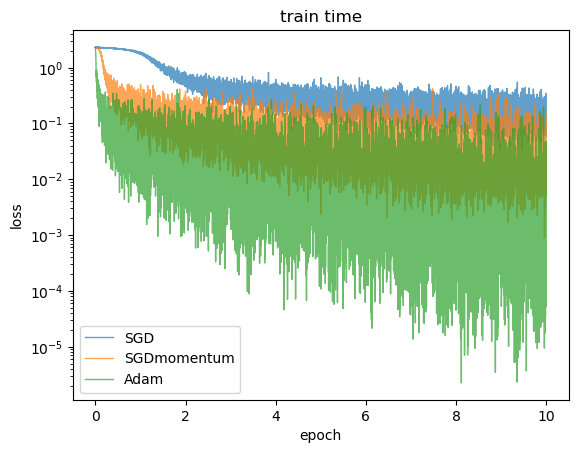

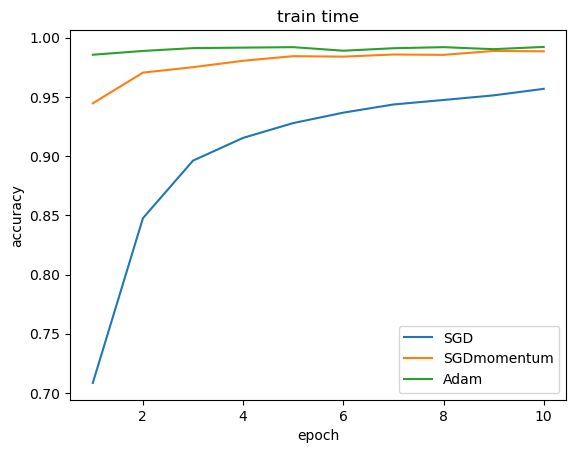

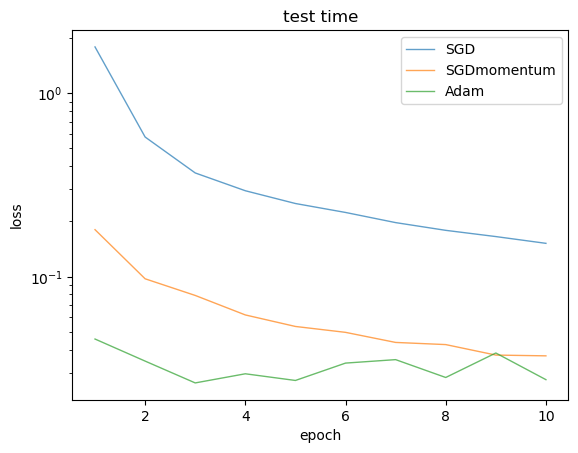

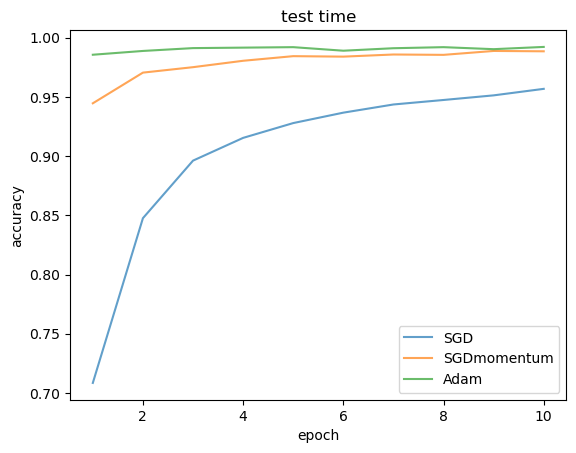

In [18]:
# Plotting the results
plt.figure()
for opt in optimizers:
    plt.plot(np.linspace(0,10,len(losses_train[opt])),losses_train[opt],label=opt,linewidth=1,alpha=0.7)
plt.yscale("log")
plt.legend()
plt.title("train time")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure()
for opt in optimizers:
    plt.plot(np.linspace(1,10,len(acc_test[opt])),acc_test[opt],label=opt)
plt.legend()
plt.title("train time")

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()



plt.figure()
for opt in optimizers:
    plt.plot(np.linspace(1,10,len(losses_test[opt])),losses_test[opt],label=opt,linewidth=1,alpha=0.7)
plt.yscale("log")
plt.legend()
plt.title("test time")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.figure()
for opt in optimizers:
    plt.plot(np.linspace(1,10,len(acc_test[opt])),acc_test[opt],label=opt,alpha=0.7)
plt.legend()
plt.title("test time")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [ ]:
# Version 3.3 - C. W. Royer, February 2025